# Face Verification Using One Shot Learning

 Face verification is the task of comparing a candidate face to another and verifying whether it is a match. It is different from face recognition. This model can be used for Facial Recognition also my making another minor change in the code. So this model uses the technique of One-Shot Learning, which means, to learn information about object categories from one, or only a few, training samples/images. So this model needs only one image of a person in order to learn information and can be used for face verification and face recognition tasks. The base model is an inception network. Various detail about the models and their plots can be found in the notebook.


## Acknowledgements

1. Florian Schroff, Dmitry Kalenichenko, James Philbin (2015).[ FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/pdf/1503.03832.pdf)
2. Yaniv Taigman, Ming Yang, Marc'Aurelio Ranzato, Lior Wolf (2014).[ DeepFace: Closing the gap to human-level performance in face verification](https://research.fb.com/wp-content/uploads/2016/11/deepface-closing-the-gap-to-human-level-performance-in-face-verification.pdf)
3. Deeplearning.ai [Deep Learning Specialization](https://www.coursera.org/specializations/deep-learning)

# Importing Libraries

In [1]:
!nvidia-smi

Tue Feb  1 12:18:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf 
import numpy as np
import os
from keras.layers import Conv2D, Activation, AveragePooling2D, MaxPooling2D, ZeroPadding2D, Input, concatenate
from keras.layers.core import Lambda, Dense, Flatten
from numpy import genfromtxt
import cv2
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.layers import *
from keras.models import Model
from sklearn.preprocessing import normalize
K.set_image_data_format('channels_first')
import random
import matplotlib.pyplot as plt
import keras
from keras.utils import plot_model
import sys
tf.debugging.set_log_device_placement(True)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


# Defining the path of dataset and haar cascade

In [3]:
path_haar='../input/haarcascade-frontalface-default/haarcascade_frontalface_default.xml'
PATH='../input/face-match/trainset'

# Analysing the dataset

In [4]:
reference_images=[]
selfies=[]
n_sub=0

In [5]:
for folder in os.listdir(PATH):
    subfolder=os.path.join(PATH,folder)
    for sub in os.listdir(subfolder):
        n_sub=n_sub+1
        img_dir=os.path.join(subfolder,sub)
        for img_raw in os.listdir(img_dir):
            if 'script' in img_raw:
                reference_images.append(img_raw)
            else :
                selfies.append(img_raw)

In [6]:
print("The total number of Folders in dataset : ",len(os.listdir(PATH)))
print("The total number of Employee in dataset : ",n_sub)
print("The total number of selfies are : ",len(selfies))
print("The total number of script images are : ",len(reference_images))

The total number of Folders in dataset :  12
The total number of Employee in dataset :  1012
The total number of selfies are :  3198
The total number of script images are :  1221


> The dataset consist of images of 1012 persons and with one reference image of each person and rest other images in different popse

In [7]:
image=cv2.imread('../input/face-match/trainset/0003/0003_0000345/0000002.jpg')

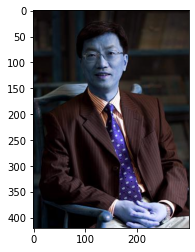

In [8]:
plt.imshow(image)
plt.show()

In [9]:
image=cv2.imread('../input/face-match/trainset/0003/0003_0000345/0003_0000345_script.jpg')

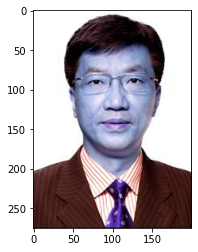

In [10]:
plt.imshow(image)
plt.show()

# Defining the Model

In [11]:
def inception_block_1a(X):
    X_3=Conv2D(96,(1,1),data_format='channels_first',name='inception_3a_3x3_conv1')(X)
    X_3=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3a_3x3_bn1')(X_3)
    X_3=Activation('relu')(X_3)
    X_3=ZeroPadding2D(padding=(1,1),data_format='channels_first')(X_3)
    X_3=Conv2D(128,(3,3),data_format='channels_first',name='inception_3a_3x3_conv2')(X_3)
    X_3=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3a_3x3_bn2')(X_3)
    X_3=Activation('relu')(X_3)
    
    X_5=Conv2D(16,(1,1),data_format='channels_first',name='inception_3a_5x5_conv1')(X)
    X_5=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3a_5x5_bn1')(X_5)
    X_5=Activation('relu')(X_5)
    X_5=ZeroPadding2D(padding=(2,2),data_format='channels_first')(X_5)
    X_5=Conv2D(32,(5,5),data_format='channels_first',name='inception_3a_5x5_conv2')(X_5)
    X_5=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3a_5x5_bn2')(X_5)
    X_5=Activation('relu')(X_5)
    
    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
    X_pool = Conv2D(32, (1, 1), data_format='channels_first', name='inception_3a_pool_conv')(X_pool)
    X_pool = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_pool_bn')(X_pool)
    X_pool = Activation('relu')(X_pool)
    X_pool = ZeroPadding2D(padding=((3, 4), (3, 4)), data_format='channels_first')(X_pool)
    
    X_1=Conv2D(64,(1,1),data_format='channels_first',name='inception_3a_1x1_conv')(X)
    X_1=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3a_1x1_bn')(X_1)
    X_1=Activation('relu')(X_1)
    
    inception=concatenate([X_3,X_5,X_pool,X_1],axis=1)
    return inception

def inception_block_1b(X):
    X_3=Conv2D(96,(1,1),data_format='channels_first',name='inception_3b_3x3_conv1')(X)
    X_3=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3b_3x3_bn1')(X_3)
    X_3=Activation('relu')(X_3)
    X_3=ZeroPadding2D(padding=(1,1),data_format='channels_first')(X_3)
    X_3=Conv2D(128,(3,3),data_format='channels_first',name='inception_3b_3x3_conv2')(X_3)
    X_3=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3b_3x3_bn2')(X_3)
    X_3=Activation('relu')(X_3)
    
    X_5=Conv2D(32,(1,1),data_format='channels_first',name='inception_3b_5x5_conv1')(X)
    X_5=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3b_5x5_bn1')(X_5)
    X_5=Activation('relu')(X_5)
    X_5=ZeroPadding2D(padding=(2,2),data_format='channels_first')(X_5)
    X_5=Conv2D(64,(5,5),data_format='channels_first',name='inception_3b_5x5_conv2')(X_5)
    X_5=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3b_5x5_bn2')(X_5)
    X_5=Activation('relu')(X_5)
    
    X_P=AveragePooling2D(pool_size=(3,3),strides=(3,3),data_format='channels_first')(X)
    X_P=Conv2D(64,(1,1),data_format='channels_first',name='inception_3b_pool_conv')(X_P)
    X_P=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3b_pool_bn')(X_P)
    X_P=Activation('relu')(X_P)
    X_P=ZeroPadding2D(padding=(4,4),data_format='channels_first')(X_P)
    
    X_1=Conv2D(64,(1,1),data_format='channels_first',name='inception_3b_1x1_conv')(X)
    X_1=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3b_1x1_bn')(X_1)
    X_1=Activation('relu')(X_1)
    
    inception=concatenate([X_3,X_5,X_P,X_1],axis=1)
    return inception

def inception_block_1c(X):
    X_3=Conv2D(128,(1,1),data_format='channels_first',name='inception_3c_3x3_conv1')(X)
    X_3=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3c_3x3_bn1')(X_3)
    X_3=Activation('relu')(X_3)
    X_3=ZeroPadding2D(padding=(1,1),data_format='channels_first')(X_3)
    X_3=Conv2D(256,(3,3),strides=(2,2),data_format='channels_first',name='inception_3c_3x3_conv2')(X_3)
    X_3=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3c_3x3_bn2')(X_3)
    X_3=Activation('relu')(X_3)
    
    X_5=Conv2D(32,(1,1),data_format='channels_first',name='inception_3c_5x5_conv1')(X)
    X_5=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3c_5x5_bn1')(X_5)
    X_5=Activation('relu')(X_5)
    X_5=ZeroPadding2D(padding=(2,2),data_format='channels_first')(X_5)
    X_5=Conv2D(64,(5,5),strides=(2,2),data_format='channels_first',name='inception_3c_5x5_conv2')(X_5)
    X_5=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3c_5x5_bn2')(X_5)
    X_5=Activation('relu')(X_5)
    
    X_P=MaxPooling2D(pool_size=3,strides=2,data_format='channels_first')(X)
    X_P=ZeroPadding2D(padding=((0,1),(0,1)),data_format='channels_first')(X_P)
    

    inception=concatenate([X_3,X_5,X_P],axis=1)
    return inception

def inception_block_2a(X):
    X_3=Conv2D(96,(1,1),data_format='channels_first',name='inception_4a_3x3_conv1')(X)
    X_3=BatchNormalization(axis=1,epsilon=0.00001,name='inception_4a_3x3_bn1')(X_3)
    X_3=Activation('relu')(X_3)
    X_3=ZeroPadding2D(padding=(1,1),data_format='channels_first')(X_3)
    X_3=Conv2D(192,(3,3),data_format='channels_first',name='inception_4a_3x3_conv2')(X_3)
    X_3=BatchNormalization(axis=1,epsilon=0.00001,name='inception_4a_3x3_bn2')(X_3)
    X_3=Activation('relu')(X_3)
    
    X_5=Conv2D(32,(1,1),data_format='channels_first',name='inception_4a_5x5_conv1')(X)
    X_5=BatchNormalization(axis=1,epsilon=0.00001,name='inception_4a_5x5_bn1')(X_5)
    X_5=Activation('relu')(X_5)
    X_5=ZeroPadding2D(padding=(2,2),data_format='channels_first')(X_5)
    X_5=Conv2D(64,(5,5),data_format='channels_first',name='inception_4a_5x5_conv2')(X_5)
    X_5=BatchNormalization(axis=1,epsilon=0.00001,name='inception_4a_5x5_bn2')(X_5)
    X_5=Activation('relu')(X_5)
    
    X_P=AveragePooling2D(pool_size=(3,3),strides=(3,3),data_format='channels_first')(X)
    X_P=Conv2D(128,(1,1),data_format='channels_first',name='inception_4a_pool_conv')(X_P)
    X_P=BatchNormalization(axis=1,epsilon=0.00001,name='inception_4a_pool_bn')(X_P)
    X_P=Activation('relu')(X_P)
    X_P=ZeroPadding2D(padding=(2,2),data_format='channels_first')(X_P)
    
    X_1=Conv2D(256,(1,1),data_format='channels_first',name='inception_4a_1x1_conv')(X)
    X_1=BatchNormalization(axis=1,epsilon=0.00001,name='inception_4a_1x1_bn')(X_1)
    X_1=Activation('relu')(X_1)
    
    inception=concatenate([X_3,X_5,X_P,X_1],axis=1)
    return inception

def inception_block_2b(X):
    X_3=Conv2D(160,(1,1),data_format='channels_first',name='inception_4e_3x3_conv1')(X)
    X_3=BatchNormalization(axis=1,epsilon=0.00001,name='inception_4e_3x3_bn1')(X_3)
    X_3=Activation('relu')(X_3)
    X_3=ZeroPadding2D(padding=(1,1),data_format='channels_first')(X_3)
    X_3=Conv2D(256,(3,3),strides=(2,2),data_format='channels_first',name='inception_4e_3x3_conv2')(X_3)
    X_3=BatchNormalization(axis=1,epsilon=0.00001,name='inception_4e_3x3_bn2')(X_3)
    X_3=Activation('relu')(X_3)
    
    X_5=Conv2D(64,(1,1),data_format='channels_first',name='inception_4e_5x5_conv1')(X)
    X_5=BatchNormalization(axis=1,epsilon=0.00001,name='inception_4e_5x5_bn1')(X_5)
    X_5=Activation('relu')(X_5)
    X_5=ZeroPadding2D(padding=(2,2),data_format='channels_first')(X_5)
    X_5=Conv2D(128,(5,5),strides=(2,2),data_format='channels_first',name='inception_4e_5x5_conv2')(X_5)
    X_5=BatchNormalization(axis=1,epsilon=0.00001,name='inception_4e_5x5_bn2')(X_5)
    X_5=Activation('relu')(X_5)
    
    X_P=MaxPooling2D(pool_size=3,strides=2,data_format='channels_first')(X)
    X_P=ZeroPadding2D(padding=((0,1),(0,1)),data_format='channels_first')(X_P)

    inception=concatenate([X_3,X_5,X_P],axis=1)
    return inception

def inception_block_3a(X):
    X_3=Conv2D(96,(1,1),data_format='channels_first',name='inception_5a_3x3_conv1')(X)
    X_3=BatchNormalization(axis=1,epsilon=0.00001,name='inception_5a_3x3_bn1')(X_3)
    X_3=Activation('relu')(X_3)
    X_3=ZeroPadding2D(padding=(1,1),data_format='channels_first')(X_3)
    X_3=Conv2D(384,(3,3),data_format='channels_first',name='inception_5a_3x3_conv2')(X_3)
    X_3=BatchNormalization(axis=1,epsilon=0.00001,name='inception_5a_3x3_bn2')(X_3)
    X_3=Activation('relu')(X_3)

    
    X_P=AveragePooling2D(pool_size=(3,3),strides=(3,3),data_format='channels_first')(X)
    X_P=Conv2D(96,(1,1),data_format='channels_first',name='inception_5a_pool_conv')(X_P)
    X_P=BatchNormalization(axis=1,epsilon=0.00001,name='inception_5a_pool_bn')(X_P)
    X_P=Activation('relu')(X_P)
    X_P=ZeroPadding2D(padding=(1,1),data_format='channels_first')(X_P)
    
    X_1=Conv2D(256,(1,1),data_format='channels_first',name='inception_5a_1x1_conv')(X)
    X_1=BatchNormalization(axis=1,epsilon=0.00001,name='inception_5a_1x1_bn')(X_1)
    X_1=Activation('relu')(X_1)
    
    inception=concatenate([X_3,X_P,X_1],axis=1)
    return inception
def inception_block_3b(X):
    X_3=Conv2D(96,(1,1),data_format='channels_first',name='inception_5b_3x3_conv1')(X)
    X_3=BatchNormalization(axis=1,epsilon=0.00001,name='inception_5b_3x3_bn1')(X_3)
    X_3=Activation('relu')(X_3)
    X_3=ZeroPadding2D(padding=(1,1),data_format='channels_first')(X_3)
    X_3=Conv2D(384,(3,3),data_format='channels_first',name='inception_5b_3x3_conv2')(X_3)
    X_3=BatchNormalization(axis=1,epsilon=0.00001,name='inception_5b_3x3_bn2')(X_3)
    X_3=Activation('relu')(X_3)
    
    
    X_P=MaxPooling2D(pool_size=(3,3),strides=2,data_format='channels_first')(X)
    X_P=Conv2D(96,(1,1),data_format='channels_first',name='inception_5b_pool_conv')(X_P)
    X_P=BatchNormalization(axis=1,epsilon=0.00001,name='inception_5b_pool_bn')(X_P)
    X_P=Activation('relu')(X_P)
    X_P=ZeroPadding2D(padding=(1,1),data_format='channels_first')(X_P)
    
    X_1=Conv2D(256,(1,1),data_format='channels_first',name='inception_5b_1x1_conv')(X)
    X_1=BatchNormalization(axis=1,epsilon=0.00001,name='inception_5b_1x1_bn')(X_1)
    X_1=Activation('relu')(X_1)
    
    inception=concatenate([X_3,X_P,X_1],axis=1)
    return inception


def FinalModel(input_shape):
    
    X_input=Input(input_shape)
    
    X=ZeroPadding2D(padding=(3,3))(X_input)
    X=Conv2D(64,(7,7),strides=(2,2),name='conv1')(X)
    X=BatchNormalization(axis=1,name='bn1')(X)
    X=Activation('relu')(X)
    
    X=ZeroPadding2D((1,1))(X)
    X=MaxPooling2D((3,3),strides=2)(X)
    
    X=Conv2D(64,(1,1),strides=(1,1),name='conv2')(X)
    X=BatchNormalization(axis=1,epsilon=0.00001,name='bn2')(X)
    X=Activation('relu')(X) 
    
    X=ZeroPadding2D(padding=(1,1))(X)
    
    X=Conv2D(192,(3,3),strides=(1,1),name='conv3')(X)
    X=BatchNormalization(axis=1,epsilon=0.00001,name='bn3')(X)
    X=Activation('relu')(X)
    
    X=ZeroPadding2D(padding=(1,1))(X)
    X=MaxPooling2D(pool_size=(3,3),strides=(2,2))(X)
    
    X=inception_block_1a(X)
    X=inception_block_1b(X)
    X=inception_block_1c(X)
    
    X=inception_block_2a(X)
    X=inception_block_2b(X)
    
    X=inception_block_3a(X)
    X=inception_block_3b(X)
    
    X=AveragePooling2D(pool_size=(3,3),strides=(1,1),data_format='channels_first')(X)
    X=Flatten()(X)
    X=Dense(128,activation='relu',kernel_initializer='glorot_normal',name='dense_layer')(X)
    X=Lambda(lambda x:K.l2_normalize(x,axis=1),name='lambda_1')(X)
    
    model=Model(inputs=X_input,outputs=X,name='FaceRecognotionModel')
    return model    


In [15]:
model=FinalModel(input_shape=(3,96,96))

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica

In [16]:
model.summary()

Model: "FaceRecognotionModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 3, 96, 96)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_23 (ZeroPadding2 (None, 3, 102, 102)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 48, 48)   9472        zero_padding2d_23[0][0]          
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 64, 48, 48)   256         conv1[0][0]                      
_______________________________________________________________________________

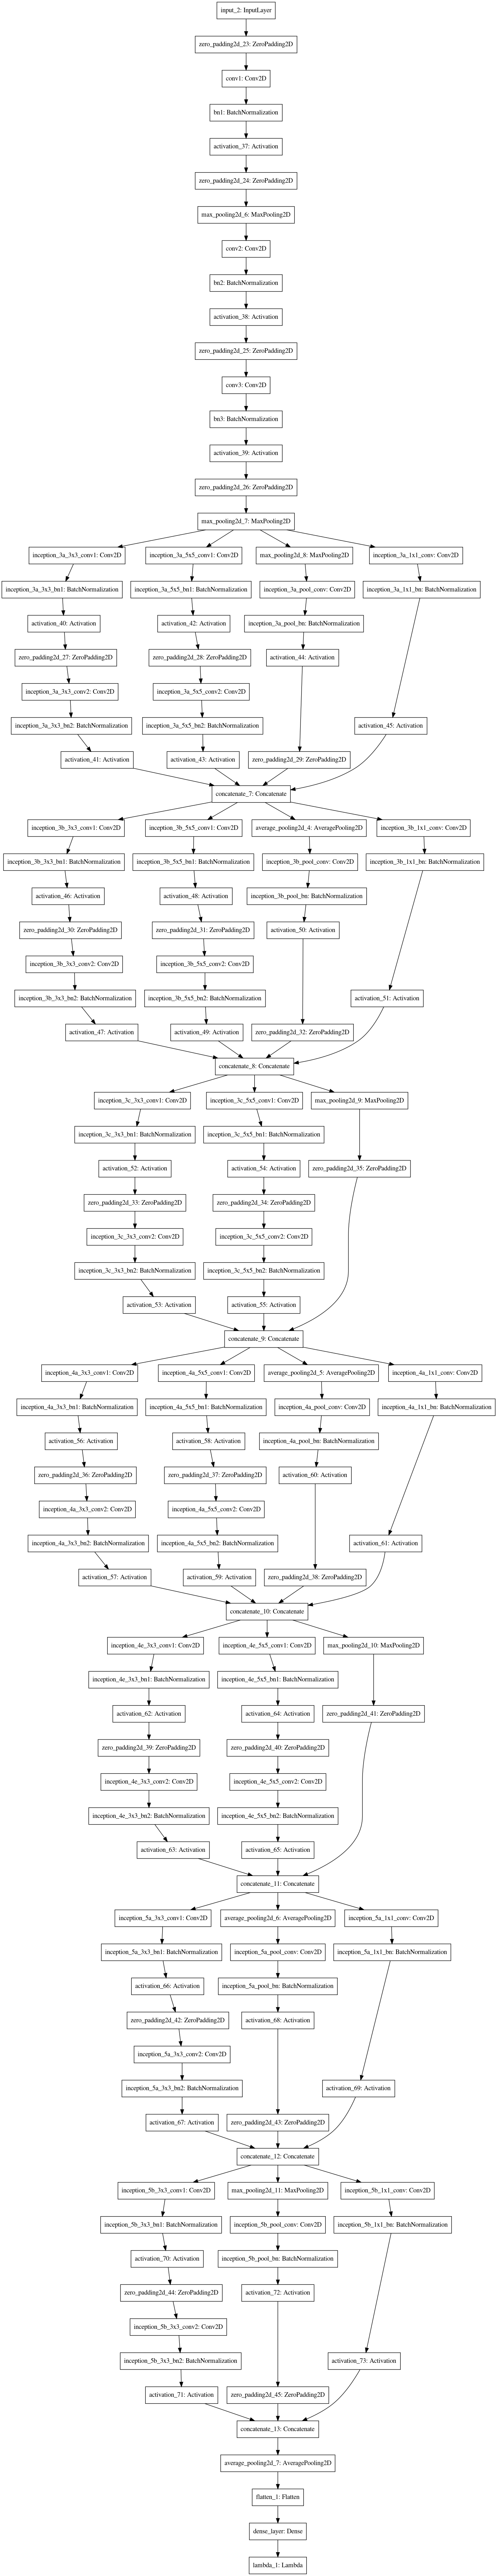

In [17]:
plot_model(model,to_file='Inception_one_shot.png')

# Defining the Triplet Loss Function

In [18]:
def triplet_loss_t(y_true,y_pred):
    #print(y_pred)
    anchor=y_pred[:,0:128]
    pos=y_pred[:,128:256]
    neg=y_pred[:,256:384]
    
    positive_distance = K.sum(K.abs(anchor-pos), axis=1)
    negative_distance = K.sum(K.abs(anchor-neg), axis=1)
    probs=K.softmax([positive_distance,negative_distance],axis=0)
    #loss = positive_distance - negative_distance+alpha
    loss=K.mean(K.abs(probs[0])+K.abs(1.0-probs[1]))
    return loss

### Function to resize the image to match the input shape of the model

In [19]:
def localize_resize(path_image,path_haar='/kaggle/input/haarcascade-frontalface-default/haarcascade_frontalface_default.xml'):
#     fileee= open(path_haar,'r')
    image=cv2.imread(path_image)
    
    gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    classifier=cv2.CascadeClassifier(path_haar)
    faces=classifier.detectMultiScale(gray,1.1,6)
    if len(faces) != 1:#condition if we dont have any faces or cant be detected y haar cascade we will skip those
        return -1
    
    x,y,w,h=faces.squeeze()
    crop=image[y:y+h,x:x+w]
    image=cv2.resize(crop,(96,96))
    image=np.transpose(image,(2,0,1))
    image=image.astype('float32')/255.0
    return image

## Definig the generator

In [20]:
def data_gen(batch_size=32):
    while True:
        i=0
        positive=[]
        anchor=[]
        negative=[]    
        

        while(i<batch_size):
            r=random.choice(os.listdir(PATH))
            p=PATH+'/'+ r
            id=os.listdir(p)
            ra=random.sample(id,2)
            pos_dir=p+'/'+ra[0]
            neg_dir=p+'/'+ra[1]
            pos=pos_dir+'/'+random.choice(os.listdir(pos_dir))
            anc=pos_dir+'/'+random.choice([x for x in os.listdir(pos_dir) if 'script' in x])
            neg=neg_dir+'/'+random.choice(os.listdir(neg_dir))
            pos_img=localize_resize(pos,path_haar)
                    #print(pos+anc+neg)
            if pos_img is -1:
                continue
            neg_img=localize_resize(neg,path_haar)
            if neg_img is -1:
                continue
            anc_img=localize_resize(anc,path_haar)
            if anc_img is -1:
                continue
            positive.append(list(pos_img))
                #print('positive{0}'.format(i))
            negative.append(list(neg_img))
                #print('negative{0}'.format(i))
            anchor.append(list(anc_img))
                #print('anchor{0}'.format(i))
            i=i+1
        #return anchor,positive,negative
        yield ([np.array(anchor),np.array(positive),np.array(negative)],np.zeros((batch_size,1)).astype("float32"))

## Defining model for triplet loss

In [21]:
triplet_model_a=Input((3,96,96))
triplet_model_n=Input((3,96,96))
triplet_model_p=Input((3,96,96))
triplet_model_out=Concatenate()([model(triplet_model_a),model(triplet_model_p),model(triplet_model_n)])
triplet_model=Model([triplet_model_a,triplet_model_p,triplet_model_n],triplet_model_out)

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalN

In [22]:
triplet_model.compile(optimizer='adam',loss=triplet_loss_t)

Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:lo

In [23]:
triplet_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 3, 96, 96)]  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 3, 96, 96)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 3, 96, 96)]  0                                            
__________________________________________________________________________________________________
FaceRecognotionModel (Functiona (None, 128)          3743280     input_3[0][0]                    
                                                                 input_5[0][0]         

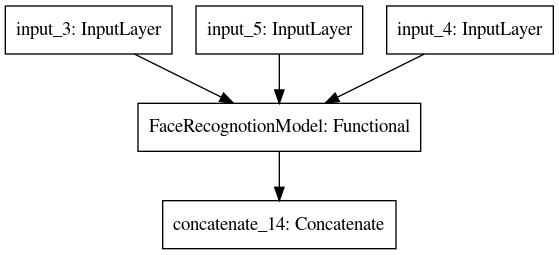

In [24]:
plot_model(triplet_model)

## Training the model
> We will be training the model for 5 epoch and with steps_per_epoch as 100  .These hyperparameters can be changed as per the availablity of computional power

>  Since batch size is 32 and total number of samples is almost 3200 so steps_per_epoch=100

### Using the model trained in version 1. For details please refer version 1.

In [25]:
triplet_model.fit(data_gen(),steps_per_epoch=100,epochs=5)

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Epoch 1/5
Ex

In [26]:
triplet_model.save('triplet_model.h5')

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

In [29]:
triplet_model=keras.models.load_model('./triplet_model.h5',custom_objects={'triplet_loss_t':triplet_loss_t})

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica

# **Implementation of the model**

## Function to preprocess the image according to the model requirements. 

> It uses haar cascade to detect the face and crops the face to remove the unwanted noise from the image and then resize it to (96,96).

In [30]:
#To loacaloze the face and resize the image
def image_resizing(image,path_haar):

    gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    classifier=cv2.CascadeClassifier(path_haar)
    faces=classifier.detectMultiScale(gray,1.1,6)

    if len(faces)!=1:
        print('More than one Image in the selfie')
        sys.exit(0)
    x,y,w,h=faces.squeeze()
    crop=image[y:y+h,x:x+w]
    image=cv2.resize(crop,(96,96))

    return image

## Function to convert the image to embeddings.

>It normalizes the image matrix and transpose it since here we are using the 'Channels First' data format. Then it uses the base model to predict the embedding for the provided image

In [31]:
def encode_img(img1,triplet_model):
    #img1=cv2.imread(path,1)
    img=img1[...,::-1]
    img=np.around(np.transpose(img,(2,0,1))/255,decimals=12)
    x_train=np.array([img])
    emb=triplet_model.layers[3].predict_on_batch(x_train)
    return emb

## Function to calculate the distance between the embeddings and confidence score

>  Selecting the threshold value as 0.65 and intervals means that +/- 0.3 the model confidence score will be 100%.

In [32]:
threshold=0.65
interval=0.3
def confidence_value(ref_encode,img_encode,thres=threshold):
    #diff=np.max(img_encode-ref_encode)
    dist=np.linalg.norm((img_encode-ref_encode))
    #confidence=(1-K.eval(tf.minimum(dist,1)))
    confidence=(threshold-max([dist,interval]))/(threshold-interval)
    return dist,confidence

### For images of same person

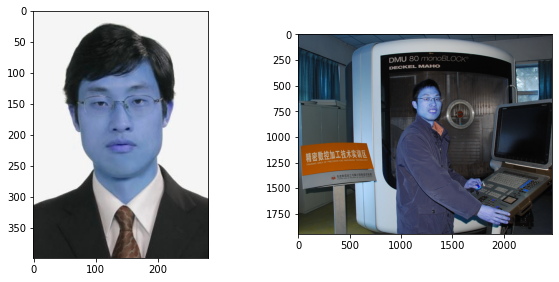

In [33]:
rimage=cv2.imread('../input/face-match/trainset/0006/0006_0000557/0006_0000557_script.jpg')
image=cv2.imread('../input/face-match/trainset/0006/0006_0000557/0000000.jpg')

fig=plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(rimage)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(image)

In [34]:
rimage=cv2.imread('../input/face-match/trainset/0006/0006_0000557/0006_0000557_script.jpg')
image=cv2.imread('../input/face-match/trainset/0006/0006_0000557/0000000.jpg')
rimg=image_resizing(rimage,path_haar)
img=image_resizing(image,path_haar)
r_encode=encode_img(rimg,triplet_model)
img_encode=encode_img(img,triplet_model)
dist,conf=confidence_value(r_encode,img_encode)
if dist<threshold:
    print("Match with a confidence of ",conf*100)
    #print("Distance ",dist)
else:
    print("No Match with a confidence of ",abs(conf*100))

Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_41751 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/ta

### For images of different persons

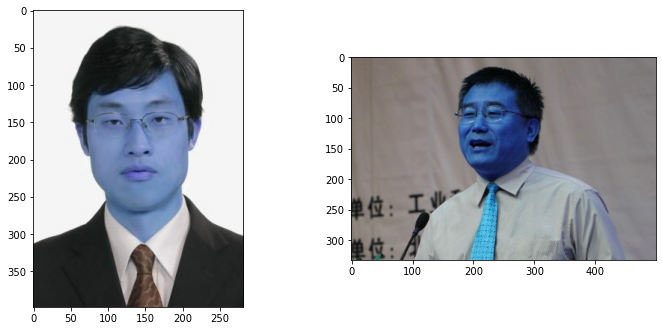

In [35]:
rimage=cv2.imread('../input/face-match/trainset/0006/0006_0000557/0006_0000557_script.jpg')
image=cv2.imread('../input/face-match/trainset/0002/0002_0000308/0000001.jpg')

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(rimage)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(image)

In [36]:
rimage=cv2.imread('../input/face-match/trainset/0006/0006_0000557/0006_0000557_script.jpg')
image=cv2.imread('../input/face-match/trainset/0002/0002_0000308/0000001.jpg')
rimg=image_resizing(rimage,path_haar)
img=image_resizing(image,path_haar)
r_encode=encode_img(rimg,triplet_model)
img_encode=encode_img(img,triplet_model)
dist,conf=confidence_value(r_encode,img_encode)
if dist<threshold:
    print("Match with a confidence of ",conf*100)
    #print("Distance ",dist)
else:
    print("No Match with a confidence of ",abs(conf*100))

Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_41751 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/ta